# Keyhole Conduction Mode Overlap Regions
For SS316L, Ti-6Al-4V, IN718

In [1]:
import pandas as pd

df = pd.read_csv('./meltpoolnet_classification.csv')

# Column names
material_col = 'Material'
process_col = 'Process'
layer_height_col = 'layer thickness'

# Filter to SS316L and IN718, PBF process only
df_pbf = df[
    (df[material_col].isin(['SS316L', 'IN718'])) & 
    (df[process_col].str.contains('PBF', case=False, na=False))
].copy()

# Convert layer height to numeric
df_pbf[layer_height_col] = pd.to_numeric(df_pbf[layer_height_col], errors='coerce')

# Filter by layer height: SS316L → 50 μm, IN718 → 70 μm
df_pbf = pd.concat([
    df_pbf[(df_pbf[material_col] == 'SS316L') & (df_pbf[layer_height_col] == 50)],
    df_pbf[(df_pbf[material_col] == 'IN718') & (df_pbf[layer_height_col] == 70)]
], ignore_index=True)

print(f'Rows: {len(df_pbf)}')
print(df_pbf[material_col].value_counts())

Rows: 240
Material
SS316L    195
IN718      45
Name: count, dtype: int64


SS316L - With Keyhole: P = 0.505*V + 187.4
SS316L - LoF Only:    P = 0.236*V + 241.6
IN718 - With Keyhole: P = 0.300*V + -0.0
IN718 - LoF Only:    P = 0.134*V + 8.6


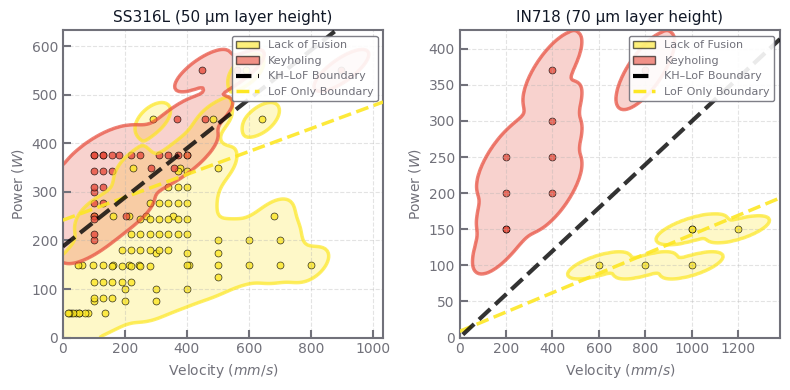

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter

# --- Styling ---
for key in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color', 'axes.edgecolor', 'legend.edgecolor']:
    plt.rcParams[key] = '#71717A'
plt.rcParams['axes.linewidth'] = 1.5

# --- Column names ---
power_col, velocity_col, melt_col = 'Power', 'Velocity', 'meltpool shape'

# --- Prepare data ---
df_plot = df_pbf[[power_col, velocity_col, melt_col, material_col]].copy()
df_plot[power_col] = pd.to_numeric(df_plot[power_col], errors='coerce')
df_plot[velocity_col] = pd.to_numeric(df_plot[velocity_col], errors='coerce')
df_plot = df_plot.dropna()

# --- Match defect classes (keyholing and lack of fusion only) ---
target_keywords = {'keyholing': ['keyhole'], 'lack of fusion': ['lack', 'fusion', 'lof']}
class_mapping = {}
for cls in df_plot[melt_col].unique():
    cls_clean = str(cls).lower().replace(' ', '').replace('_', '')
    for target, keywords in target_keywords.items():
        if any(kw in cls_clean for kw in keywords):
            class_mapping[cls] = target
            break

matched_classes = list(class_mapping.keys())
df_plot = df_plot[df_plot[melt_col].isin(matched_classes)]

# --- Colors ---
colors = {'keyholing': '#e74c3c', 'lack of fusion': '#fde724'}
class_colors = {cls: colors[class_mapping[cls]] for cls in matched_classes}

# --- Bootstrap boundary fitting ---
def fit_boundary(kh_v, kh_p, lof_v, lof_p, n_bins=20):
    """Fit linear boundary between keyhole and LoF"""
    v_min = min(kh_v.min(), lof_v.min())
    v_max = max(kh_v.max(), lof_v.max())
    v_bins = np.linspace(v_min, v_max, n_bins)
    boundary_v, boundary_p = [], []
    
    for i in range(len(v_bins) - 1):
        kh_in = kh_p[(kh_v >= v_bins[i]) & (kh_v < v_bins[i+1])]
        lof_in = lof_p[(lof_v >= v_bins[i]) & (lof_v < v_bins[i+1])]
        if len(kh_in) > 0 and len(lof_in) > 0:
            boundary_v.append((v_bins[i] + v_bins[i+1]) / 2)
            boundary_p.append((lof_in.max() + kh_in.min()) / 2)
    
    if len(boundary_v) >= 2:
        return np.polyfit(boundary_v, boundary_p, 1)
    return None

def fit_lof_upper_envelope(lof_v, lof_p, n_bins=15):
    """Fit line to upper envelope of LoF region (keyhole ignored)"""
    v_bins = np.linspace(lof_v.min(), lof_v.max(), n_bins)
    boundary_v, boundary_p = [], []
    for i in range(len(v_bins) - 1):
        mask = (lof_v >= v_bins[i]) & (lof_v < v_bins[i+1])
        if mask.sum() > 0:
            boundary_v.append((v_bins[i] + v_bins[i+1]) / 2)
            boundary_p.append(lof_p[mask].max())
    if len(boundary_v) >= 2:
        return np.polyfit(boundary_v, boundary_p, 1)
    return None

# --- Plot ---
materials = [m for m in ['SS316L', 'IN718'] if m in df_plot[material_col].values]
fig, axes = plt.subplots(1, len(materials), figsize=(4*len(materials), 4))
axes = [axes] if len(materials) == 1 else axes

for ax, mat in zip(axes, materials):
    # Tick styling - thicker, pointing inward
    ax.tick_params(axis='both', which='major', direction='in', length=6, width=1.5, labelsize=10)
    ax.tick_params(axis='both', which='minor', direction='in', length=3, width=1)
    
    sub = df_plot[df_plot[material_col] == mat]
    x_max, y_max = sub[velocity_col].max() * 1.15, sub[power_col].max() * 1.15
    
    # Density contours
    for cls in matched_classes:
        data = sub[sub[melt_col] == cls]
        if len(data) >= 5:
            try:
                X, Y = data[velocity_col].values, data[power_col].values
                xi, yi = np.linspace(0, x_max, 150), np.linspace(0, y_max, 150)
                Xi, Yi = np.meshgrid(xi, yi)
                kernel = gaussian_kde(np.vstack([X, Y]), bw_method=0.3)
                Zi = gaussian_filter(kernel(np.vstack([Xi.ravel(), Yi.ravel()])).reshape(Xi.shape), sigma=1.0)
                thresh = 0.05 * Zi.max()
                ax.contourf(Xi, Yi, Zi, levels=[thresh, Zi.max()], colors=[class_colors[cls]], alpha=0.25)
                ax.contour(Xi, Yi, Zi, levels=[thresh], colors=[class_colors[cls]], linewidths=2.5, alpha=0.7)
            except: pass
    
    # Linear boundary with bootstrap CI
    keyhole_cls = next((c for c, t in class_mapping.items() if t == 'keyholing'), None)
    lof_cls = next((c for c, t in class_mapping.items() if t == 'lack of fusion'), None)
    
    if keyhole_cls and lof_cls:
        kh = sub[sub[melt_col] == keyhole_cls]
        lof = sub[sub[melt_col] == lof_cls]
        
        if len(kh) > 0 and len(lof) > 0:
            kh_v, kh_p = kh[velocity_col].values, kh[power_col].values
            lof_v, lof_p = lof[velocity_col].values, lof[power_col].values
            
            # --- Boundary 1: Keyhole vs LoF (original) ---
            coeffs = fit_boundary(kh_v, kh_p, lof_v, lof_p)
            
            # Fallback to logistic regression if not enough overlap
            if coeffs is None:
                from sklearn.linear_model import LogisticRegression
                X_all = np.concatenate([kh_v, lof_v])
                Y_all = np.concatenate([kh_p, lof_p])
                labels = np.concatenate([np.ones(len(kh)), np.zeros(len(lof))])
                lr = LogisticRegression()
                lr.fit(np.column_stack([X_all, Y_all]), labels)
                w0, w1 = lr.coef_[0]
                b = lr.intercept_[0]
                if w1 != 0:
                    coeffs = [-w0/w1, -b/w1]
            
            if coeffs is not None:
                xx = np.linspace(0, x_max, 100)
                yy_mean = coeffs[0] * xx + coeffs[1]
                mask = (yy_mean >= 0) & (yy_mean <= y_max)
                ax.plot(xx[mask], yy_mean[mask], 'k--', linewidth=3, alpha=0.8, zorder=10)
                print(f'{mat} - With Keyhole: P = {coeffs[0]:.3f}*V + {coeffs[1]:.1f}')
            
            # --- Boundary 2: LoF upper envelope (keyhole ignored) ---
            coeffs_lof = fit_lof_upper_envelope(lof_v, lof_p)
            
            if coeffs_lof is not None:
                xx = np.linspace(0, x_max, 100)
                yy_mean_lof = coeffs_lof[0] * xx + coeffs_lof[1]
                mask_lof = (yy_mean_lof >= 0) & (yy_mean_lof <= y_max)
                ax.plot(xx[mask_lof], yy_mean_lof[mask_lof], '--', color='#fde724', 
                        linewidth=2.5, alpha=0.9, zorder=9)
                print(f'{mat} - LoF Only:    P = {coeffs_lof[0]:.3f}*V + {coeffs_lof[1]:.1f}')
    
    # Scatter points
    for cls in matched_classes:
        data = sub[sub[melt_col] == cls]
        ax.scatter(data[velocity_col], data[power_col], c=class_colors[cls], 
                   edgecolor='k', s=25, alpha=0.8, linewidths=0.5)
    
    # Formatting
    layer = {'SS316L': '50 μm', 'IN718': '70 μm'}.get(mat, '')
    ax.set_title(f'{mat} ({layer} layer height)' if layer else mat, fontsize=11, color='#111827')
    ax.set(xlabel=r'Velocity ($mm/s$)', ylabel=r'Power ($W$)', xlim=(0, x_max), ylim=(0, y_max))
    ax.grid(True, linestyle='--', alpha=0.35)
    
    # Legend
    handles = [Patch(facecolor=class_colors[c], edgecolor='k', alpha=0.6,
                     label='Keyholing' if class_mapping[c] == 'keyholing' else 'Lack of Fusion') 
               for c in matched_classes]
    handles.append(Line2D([0], [0], color='k', linewidth=3, linestyle='--', label='KH–LoF Boundary'))
    handles.append(Line2D([0], [0], color='#fde724', linewidth=2.5, linestyle='--', label='LoF Only Boundary'))
    ax.legend(handles=handles, loc='upper right', fontsize=8, framealpha=0.9).set_zorder(100)

plt.tight_layout()
plt.savefig('figure_keyhole_lof_boundary.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()